#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 17

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 169 # [m]
Xg = 78 # [m]
mn = 123000000 # mass of the vessel, [kg]  Solitaire type vessel 
kp, kd=1.95e4,1.5e4

In [8]:
vessel_mass=mn/L # mass over length of the vessel

In [9]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [10]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [11]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [12]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [13]:
Irho+=vessel_inertia

In [14]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [15]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [16]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [17]:
DT=np.diag(diag_DT) # (35) in [2]

In [18]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [19]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [20]:
CT=np.diag(diag_CT)

In [21]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [22]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [23]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [24]:
rng = np.random.default_rng()

In [25]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [26]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [27]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.16057467,  0.48040551, -0.86222173],
       [ 0.8367606 ,  0.39705848,  0.37706268],
       [ 0.52349544, -0.78201989, -0.33822687]])

In [28]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.007653


In [29]:
Ret.shape

(17, 3, 3)

In [30]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def C1(dx,dy,dz, Ret):
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))) 
    return ans.T

In [32]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000876


In [33]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [34]:
fD(dx,dy,dz,DT,Ret).T

array([[-1.09266943e+04,  5.92643488e+03,  5.20658294e+03],
       [ 6.66717758e+03,  4.07310065e+03, -3.83039680e+01],
       [ 6.07561037e+03, -1.24585979e+04, -1.74392942e+04],
       [-6.61487445e+03, -1.21746201e+04,  8.49193112e+03],
       [-1.39504392e+04, -1.98299032e+04, -1.11458053e+04],
       [ 2.41251208e+03, -2.35074231e+03, -3.18584150e+02],
       [-1.47805499e+04, -1.12538692e+04,  4.05165659e+03],
       [ 1.56195194e+04, -8.19290119e+03,  2.08017044e+04],
       [-9.55095008e+02, -6.90423566e+03,  1.01230942e+03],
       [ 3.22703762e+03,  8.50461905e+03, -4.58444397e+03],
       [-9.49642286e+02,  2.28182835e+03,  6.33947433e+03],
       [ 1.92610473e+03,  2.45689559e+03,  8.19771315e+01],
       [-5.51138973e+01, -7.47133396e+03,  4.58046534e+03],
       [-2.04507395e+03, -7.32415850e+03,  7.00740714e+03],
       [ 8.22944749e+00, -1.51095971e+02, -9.18080977e+02],
       [ 3.40064854e+04,  1.75963044e+04, -5.75624478e+03],
       [ 1.53794505e+04, -4.17782155e+02

In [35]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000720


In [36]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [37]:
I=np.identity(3)

In [38]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000384


In [39]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [40]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [41]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [42]:
DR=np.diag(diag_DR) 

In [43]:
Ar

0.08091250419136858

In [44]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [45]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [46]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)

In [47]:
def Re_b(Ret):
    return Ret

In [48]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000139


In [49]:
def phi(x, y, z, Ret,dummy):
    B=np.vstack([x,y,z])
    return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [50]:
phi(x,y,z,Ret,None)

array([[-162.86609678,   69.19548319,  -81.62205902],
       [ -84.6216521 ,   10.65587061,    1.85579113],
       [ -28.87595659,   28.16630034,  -16.1855422 ],
       [ 100.56422241, -122.62720242, -112.27009884],
       [ -22.00100435,   57.58482   ,   54.81100958],
       [ 115.55284528,  -57.52825276, -162.32155713],
       [-197.39000039,   39.39963316,  136.62266753],
       [ -16.63735106,  -87.05414229, -184.39250797],
       [  -5.8531665 ,  252.87936578, -143.91757514],
       [-182.86678231, -108.6055884 ,  -22.87111132],
       [  18.01300459,    7.09036681,   27.59274179],
       [ -60.40259995,  -52.79370138, -129.71502491],
       [-150.71955584,  -91.27561864,   48.19501657],
       [  23.40442377,  -41.50147429,  -41.67631937],
       [  14.49941759, -128.7017539 , -141.49909329],
       [  -3.98563964,  -96.17065118, -106.6244961 ],
       [  28.69355383,  -70.74391643,    0.35433279]])

In [51]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None)
print(datetime.now() - startTime1)

0:00:00.000375


In [52]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [53]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [54]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001025


In [55]:
def ωe(φ,θ,ψ, dummy,dummy1):  # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [56]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None)
print(datetime.now() - startTime1)

0:00:00.002409


In [57]:
ωe(φ,θ,ψ,None,None)

array([[-1.51537842, -3.51138135,  0.08356612],
       [ 0.09167631, -1.31143845,  0.51922188],
       [-0.07721519, -0.8283674 , -0.47290128],
       [-0.21713623, -0.78071463, -0.30142169],
       [ 0.50399869,  1.65066059, -1.45405512],
       [ 0.37288417, -1.00333642, -0.80225381],
       [ 0.03725834,  0.63506101, -1.76138141],
       [-1.13141408, -1.89781545,  0.57141996],
       [-0.38182664,  2.0625077 , -0.93834544],
       [ 0.80484014, -0.55739082,  0.95912481],
       [-1.11067287,  1.16298743,  0.9178723 ],
       [-1.47046247, -0.2151582 , -0.56752234],
       [ 0.99138178, -0.91222978, -0.96477097],
       [-0.63719944,  0.81090494,  0.88489613],
       [-0.68281586,  1.77434639, -1.03099344],
       [-0.00935188, -1.5620753 , -1.24859599],
       [-0.15410525, -0.6753193 ,  1.12547741]])

In [58]:
def d_s(f,a,b,c,Ret,omega):

    fun = f(a,b,c,Ret,omega)    
    
    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    
    K=np.apply_along_axis(S, 1, omega)
    return np.einsum('ijk,ik->ij',K,fun.astype(np.float32)).T

In [59]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 280.8237908 ,   -7.96651689,   26.72745545,   50.68840716,
         174.20587397,  116.71087809,  156.16150607,  399.68741559,
         -59.54290266,  116.91446454,   25.58195964,   -2.05235311,
        -132.02499573,    2.92895913, -383.75907904,   46.47719904,
          79.38139518],
       [-137.29840044,  -44.10754474,   12.4057074 ,  -54.69014389,
           4.3659978 ,  -32.17557089,  342.58874284, -218.13118759,
         -49.45927069, -156.98447421,   47.18014645, -156.46125419,
          97.63019483,   -5.84564251, -111.56663369,    3.97931441,
          32.34855122],
       [-676.74233787, -109.99919554,  -26.09476814,  105.13877037,
          65.33886603,   94.48700738,  126.8226565 ,   66.91966251,
         -84.48387656, -189.33840099,  -28.82397565,   64.63504163,
        -227.97985624,    7.46595145,   62.15260856,   -5.326493  ,
          30.27932025]])

In [60]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [61]:
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-1.50816031e-03, -8.79999112e-05, -4.43513982e-04,
         1.03570052e-04, -2.77378353e-05, -1.04792261e-03,
         9.72220592e-04, -9.73373802e-04, -3.96792958e-03,
         8.57336204e-04,  2.05021686e-04, -7.69205545e-04,
         1.39469236e-03, -1.74844900e-06, -1.27972197e-04,
        -1.04537374e-04,  7.10975394e-04],
       [-8.12415945e-04, -8.64766119e-04, -1.26899635e-04,
         2.12834432e-03, -7.68123398e-04,  2.77874873e-03,
        -3.34012049e-03,  1.67757156e-03,  1.38065900e-03,
        -1.59993603e-03, -9.58019253e-05,  6.93143269e-04,
        -1.98913543e-03,  6.50809249e-04,  1.55999783e-03,
         1.02639960e-03,  2.83389299e-04],
       [ 2.32060642e-03,  9.52767791e-04,  5.70422488e-04,
        -2.23191644e-03,  7.95861788e-04, -1.73080516e-03,
         2.36788045e-03, -7.04178290e-04,  2.58734994e-03,
         7.42582681e-04, -1.09223862e-04,  7.60776601e-05,
         5.94415178e-04, -6.49060765e-04, -1.43202307e-03,
        -9.21860140e-04, -9.9

In [62]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001887


In [63]:
def ne(x,y,z,Ret,omega):
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [64]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [65]:
d_s(ne,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 7.20726157e+01, -3.88812070e+02, -4.21792337e+02,
        -1.53462550e+02,  2.72532650e+02, -6.67445347e+02,
         1.80026448e+02,  2.75109130e+02,  1.36096962e+02,
         2.32525742e+00, -6.96480067e+01, -4.53732057e+02,
        -1.33981402e+02, -3.53143411e+01, -1.98606521e+02,
         9.41257322e+01, -1.12859759e+02],
       [ 5.57158581e+01,  3.04884438e+01, -2.25360199e+01,
        -7.58854187e+01, -2.39217620e+02,  2.08519946e+02,
        -2.01428852e+02,  1.31516677e+01, -4.16423553e+00,
        -1.24621888e+02, -3.38638636e+02,  2.22729400e+02,
         8.30500504e+01, -9.91520133e+01, -1.19989481e+02,
         1.21590648e-03,  2.54161755e+02],
       [-1.27788618e+02,  3.58324404e+02,  4.44329201e+02,
         2.29348276e+02, -3.33155747e+01,  4.58926736e+02,
         2.14020440e+01, -2.88261348e+02, -1.31932999e+02,
         1.22296625e+02,  4.08286782e+02,  2.31003564e+02,
         5.09316192e+01,  1.34466425e+02,  3.18596399e+02,
        -9.41271364e+01, -1.4

In [66]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[ 1.83765830e-04, -1.31175581e-04, -2.05505370e-05,
         2.71228080e-05, -2.47408085e-05,  1.96420578e-04,
         3.49441662e-04, -2.54853718e-05, -2.38396216e-04,
        -6.10415648e-05,  1.70577346e-05, -2.08338340e-04,
         7.00313877e-05, -4.62006502e-05,  9.96101777e-05,
         5.25277794e-05,  3.00799526e-05],
       [-1.37379894e-05,  5.21836374e-05,  2.96963732e-05,
        -1.89802685e-04,  9.09412165e-05, -7.75091632e-05,
        -4.76064904e-05, -2.39398276e-04, -1.76413040e-04,
         2.05146932e-04, -7.95953563e-06, -2.75327183e-05,
        -1.75641328e-04, -4.43986274e-05,  6.28293410e-05,
        -9.12725318e-05,  6.82797216e-05],
       [-1.70028208e-04,  7.89922060e-05, -9.14579507e-06,
         1.62679823e-04, -6.62003586e-05, -1.18911807e-04,
        -3.01835871e-04,  2.64883699e-04,  4.14809732e-04,
        -1.44105245e-04, -9.09823304e-06,  2.35871475e-04,
         1.05609801e-04,  9.05993700e-05, -1.62439718e-04,
         3.87446474e-05, -9.8

In [67]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [68]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.09266943e+04, -6.66717758e+03, -6.07561037e+03,
         6.61487445e+03,  1.39504392e+04, -2.41251208e+03,
         1.47805499e+04, -1.56195194e+04,  9.55095008e+02,
        -3.22703762e+03,  9.49642286e+02, -1.92610473e+03,
         5.51138973e+01,  2.04507395e+03, -8.22944749e+00,
        -3.40064854e+04, -1.53794505e+04],
       [-5.92643488e+03, -4.07310065e+03,  1.24585979e+04,
         1.21746201e+04,  1.98299032e+04,  2.35074231e+03,
         1.12538692e+04,  8.19290119e+03,  6.90423566e+03,
        -8.50461905e+03, -2.28182835e+03, -2.45689559e+03,
         7.47133396e+03,  7.32415850e+03,  1.51095971e+02,
        -1.75963044e+04,  4.17782155e+02],
       [-5.33474748e+03, -8.98605742e+01,  1.73111297e+04,
        -8.62009566e+03,  1.10176408e+04,  1.90419608e+02,
        -4.17982114e+03, -2.09298689e+04, -1.14047396e+03,
         4.45627943e+03, -6.46763887e+03, -2.10141674e+02,
        -4.70862988e+03, -7.13557168e+03,  7.89916435e+02,
         5.62808023e+03,  9.2

In [69]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.001704


In [70]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None))

array([[-4.14418170e+06, -1.31932666e+08, -5.98599779e+07],
       [-2.46717431e+07,  3.33652356e+08, -5.51601093e+07],
       [-3.69272939e+08,  7.50565650e+07, -3.46736182e+08],
       [-3.84496929e+08, -1.55148118e+08, -3.08610820e+08],
       [ 3.66213495e+07,  3.30573323e+06,  2.75838661e+08],
       [-1.01041520e+08,  3.57884948e+08, -3.09561066e+08],
       [ 1.28282714e+07,  3.42302668e+07,  2.14256893e+08],
       [-7.58035967e+04, -2.88336872e+08, -1.32274579e+07],
       [-3.75813384e+05, -1.32308683e+08,  3.78841871e+06],
       [-1.19123051e+08,  3.17369377e+06,  5.49895358e+06],
       [-3.32412167e+08,  7.58748775e+07,  6.22680364e+06],
       [ 2.76135957e+06,  2.33764693e+08, -2.19967831e+08],
       [-1.90722027e+06,  4.90243507e+07, -8.49571825e+07],
       [-9.25468985e+07,  4.19195819e+07,  6.60520370e+06],
       [-2.05768554e+06,  3.16538401e+08,  1.17931684e+08],
       [-3.49497278e+02, -9.41273884e+07, -1.56540180e+03],
       [-5.69839881e+07, -1.98285509e+08

In [71]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.004123


In [72]:
Re_b(Ret).shape

(17, 3, 3)

In [73]:
def Irho_e(Ret):
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans


In [74]:
Irho_e(Ret).shape

(17, 3, 3)

In [75]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000505


In [76]:
diag_CR = 1e11*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [77]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [78]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,None,omega)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [79]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None))
print(datetime.now() - startTime1)

0:00:00.006707


In [80]:
d_me_

array([[ 2.57854721e-15,  7.30931339e-10, -5.30387425e-10],
       [ 8.47511305e-15,  3.74711482e-09, -2.96375602e-10],
       [ 5.14716553e-14,  4.26238967e-09, -2.32384375e-09],
       [ 5.28794662e-14,  4.18548343e-09, -2.15236833e-09],
       [ 1.10284129e-14,  2.20996141e-11, -2.00030132e-09],
       [ 2.16914777e-14,  2.70773892e-09, -2.24651283e-09],
       [ 5.47872575e-15,  1.68326422e-10, -4.20525266e-09],
       [ 1.78847117e-16,  1.67881542e-09, -1.01653050e-10],
       [ 5.18894013e-16,  4.52306301e-09, -1.77709884e-11],
       [ 2.42141193e-14,  1.72646279e-11, -1.44185794e-10],
       [ 4.79896471e-14,  7.84127477e-10, -5.11271925e-11],
       [ 1.96907274e-15,  1.50906739e-09, -1.49621423e-09],
       [ 1.53914881e-15,  2.33443857e-10, -2.06938558e-09],
       [ 2.04610927e-14,  2.20370264e-10, -2.30151828e-10],
       [ 1.61774932e-15,  2.14092921e-09, -7.62684169e-10],
       [ 4.95701980e-18,  4.59858420e-10, -2.30387194e-14],
       [ 1.48107287e-14,  1.09631878e-09

In [81]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [82]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.09266943e+04, -6.66717758e+03, -6.07561037e+03,
         6.61487445e+03,  1.39504392e+04, -2.41251208e+03,
         1.47805499e+04, -1.56195194e+04,  9.55095008e+02,
        -3.22703762e+03,  9.49642286e+02, -1.92610473e+03,
         5.51138973e+01,  2.04507395e+03, -8.22944749e+00,
        -3.40064854e+04, -1.53794505e+04],
       [-5.92643488e+03, -4.07310065e+03,  1.24585979e+04,
         1.21746201e+04,  1.98299032e+04,  2.35074231e+03,
         1.12538692e+04,  8.19290119e+03,  6.90423566e+03,
        -8.50461905e+03, -2.28182835e+03, -2.45689559e+03,
         7.47133396e+03,  7.32415850e+03,  1.51095971e+02,
        -1.75963044e+04,  4.17782155e+02],
       [-5.33474748e+03, -8.98605742e+01,  1.73111297e+04,
        -8.62009566e+03,  1.10176408e+04,  1.90419608e+02,
        -4.17982114e+03, -2.09298689e+04, -1.14047396e+03,
         4.45627943e+03, -6.46763887e+03, -2.10141674e+02,
        -4.70862988e+03, -7.13557168e+03,  7.89916435e+02,
         5.62808023e+03,  9.2

### Static solution

In [83]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [84]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [85]:
Fx_0=82945396

In [86]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [87]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [88]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76])

In [89]:
delta_x=horizontal_length/(node_N-1)

In [90]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [91]:
x0,z0

([0.0,
  690.7928027788513,
  1381.5856055577026,
  2072.378408336554,
  2763.171211115405,
  3453.9640138942564,
  4144.756816673108,
  4835.549619451959,
  5526.34242223081,
  6217.135225009662,
  6907.928027788513,
  7598.720830567364,
  8289.513633346216,
  8980.306436125067,
  9671.099238903918,
  10361.89204168277,
  11052.68484446162],
 [0.0,
  2.7090423503877923,
  10.836336053152266,
  24.38238107340301,
  43.34801072052057,
  67.73439169935548,
  97.54302418207908,
  132.77574190039255,
  173.43471225842703,
  219.52243646594314,
  271.0417496923585,
  327.995821240977,
  390.38815474416316,
  458.2225883786597,
  531.5032951018503,
  610.23478290842,
  694.4218951076863])

In [92]:
length_p

[690.7981147061109,
 690.8406106143384,
 690.9256050449656,
 691.0531032264977,
 691.223113002094,
 691.4356448300532,
 691.6907117844501,
 691.9883295559516,
 692.3285164527667,
 692.7112934017911,
 693.1366839498729,
 693.6047142652902,
 694.1154131393234,
 694.6688119880661,
 695.2649448543317,
 695.9038484097589]

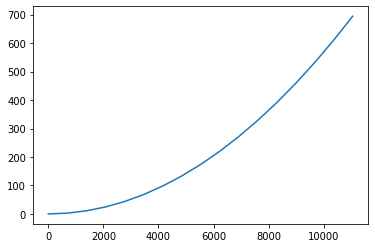

In [93]:
plt.plot(x0, z0)
plt.show()

In [94]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [95]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [96]:
def static_func(Q):
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T

############################################################    

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None))
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [97]:
q0

array([0.00000000e+00, 6.90792803e+02, 1.38158561e+03, 2.07237841e+03,
       2.76317121e+03, 3.45396401e+03, 4.14475682e+03, 4.83554962e+03,
       5.52634242e+03, 6.21713523e+03, 6.90792803e+03, 7.59872083e+03,
       8.28951363e+03, 8.98030644e+03, 9.67109924e+03, 1.03618920e+04,
       1.10526848e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [98]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [99]:
root

array([0.00000000e+00, 6.90792803e+02, 1.38158561e+03, 2.07237841e+03,
       2.76317121e+03, 3.45396401e+03, 4.14475682e+03, 4.83554962e+03,
       5.52634242e+03, 6.21713523e+03, 6.90792803e+03, 7.59872083e+03,
       8.28951363e+03, 8.98030644e+03, 9.67109924e+03, 1.03618920e+04,
       1.10526848e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [100]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [101]:
x0

[0.0,
 690.7928027788513,
 1381.5856055577026,
 2072.378408336554,
 2763.171211115405,
 3453.9640138942564,
 4144.756816673108,
 4835.549619451959,
 5526.34242223081,
 6217.135225009662,
 6907.928027788513,
 7598.720830567364,
 8289.513633346216,
 8980.306436125067,
 9671.099238903918,
 10361.89204168277,
 11052.68484446162]

In [102]:
x0_

array([    0.        ,   690.79280278,  1381.58560556,  2072.37840834,
        2763.17121112,  3453.96401389,  4144.75681667,  4835.54961945,
        5526.34242223,  6217.13522501,  6907.92802779,  7598.72083057,
        8289.51363335,  8980.30643613,  9671.0992389 , 10361.89204168,
       11052.68484446])

In [103]:
z0

[0.0,
 2.7090423503877923,
 10.836336053152266,
 24.38238107340301,
 43.34801072052057,
 67.73439169935548,
 97.54302418207908,
 132.77574190039255,
 173.43471225842703,
 219.52243646594314,
 271.0417496923585,
 327.995821240977,
 390.38815474416316,
 458.2225883786597,
 531.5032951018503,
 610.23478290842,
 694.4218951076863]

In [104]:
z0_

array([  0.        ,   2.70904235,  10.83633605,  24.38238107,
        43.34801072,  67.7343917 ,  97.54302418, 132.7757419 ,
       173.43471226, 219.52243647, 271.04174969, 327.99582124,
       390.38815474, 458.22258838, 531.5032951 , 610.23478291,
       694.42189511])

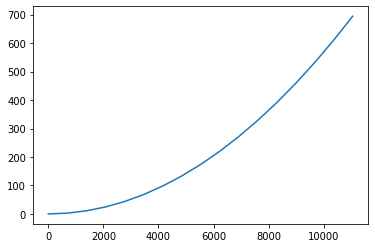

In [105]:
plt.plot(x0_, z0_)
plt.show()

In [106]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_

In [107]:
q0

array([0.00000000e+00, 6.90792803e+02, 1.38158561e+03, 2.07237841e+03,
       2.76317121e+03, 3.45396401e+03, 4.14475682e+03, 4.83554962e+03,
       5.52634242e+03, 6.21713523e+03, 6.90792803e+03, 7.59872083e+03,
       8.28951363e+03, 8.98030644e+03, 9.67109924e+03, 1.03618920e+04,
       1.10526848e+04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### Vessle Simulation

In [108]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [109]:
vehicle=semisub('DPcontrol',2,2,40.0,0,0) 

In [110]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [111]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

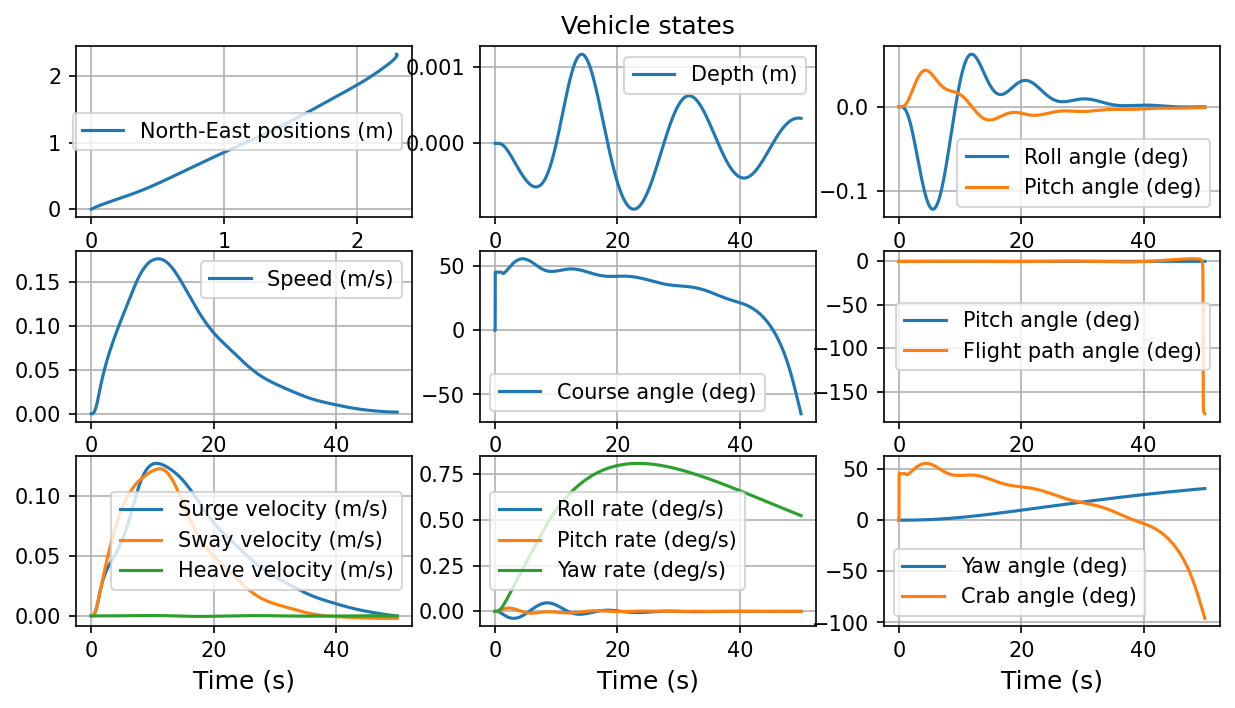

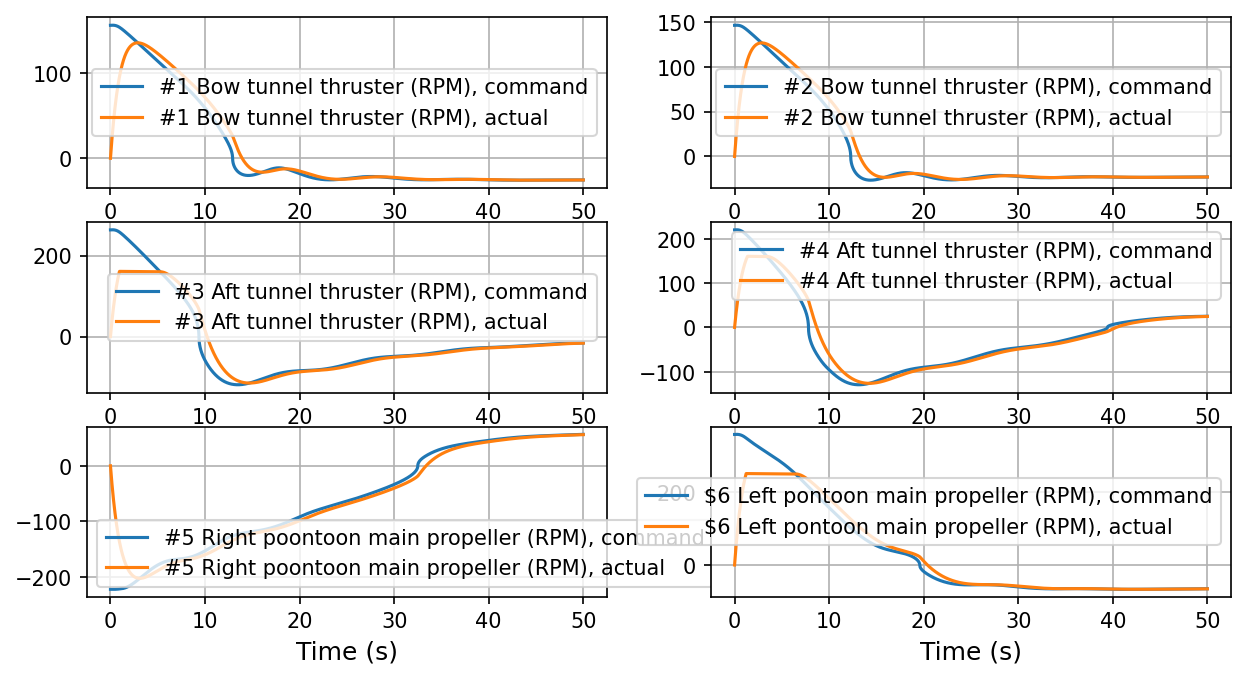

In [112]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [113]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

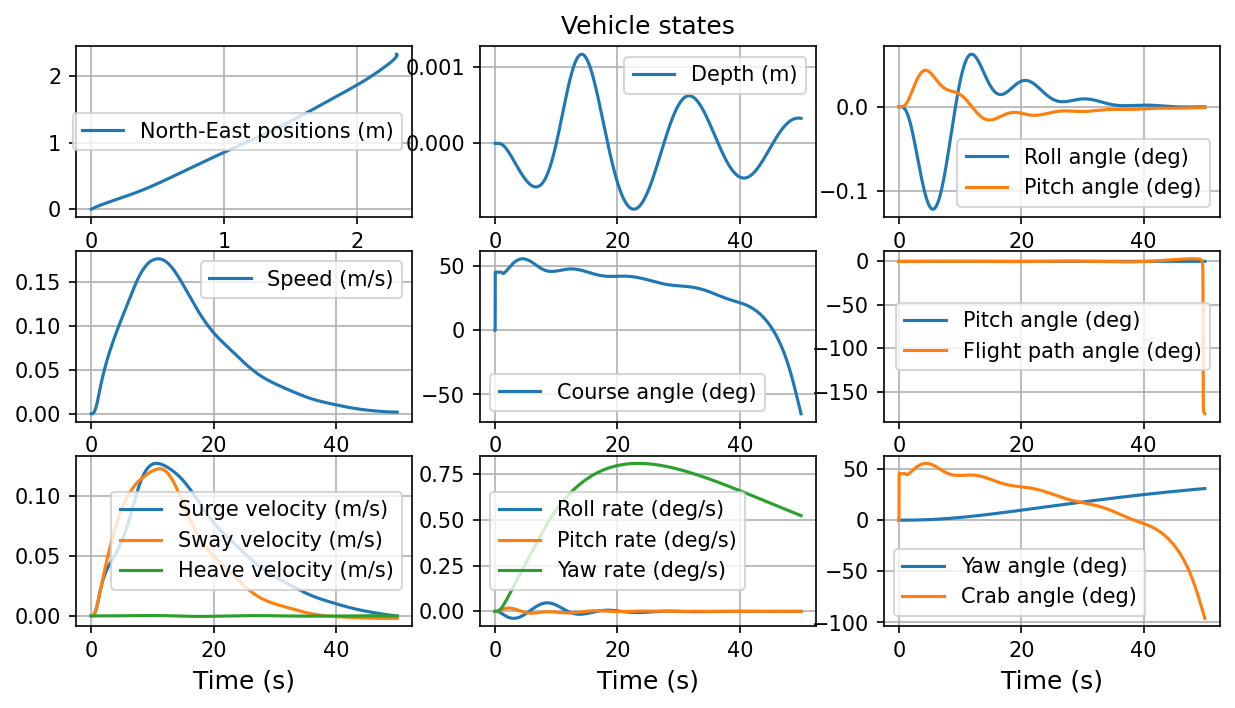

In [114]:
plotVehicleStates(simTime, simData, 3)

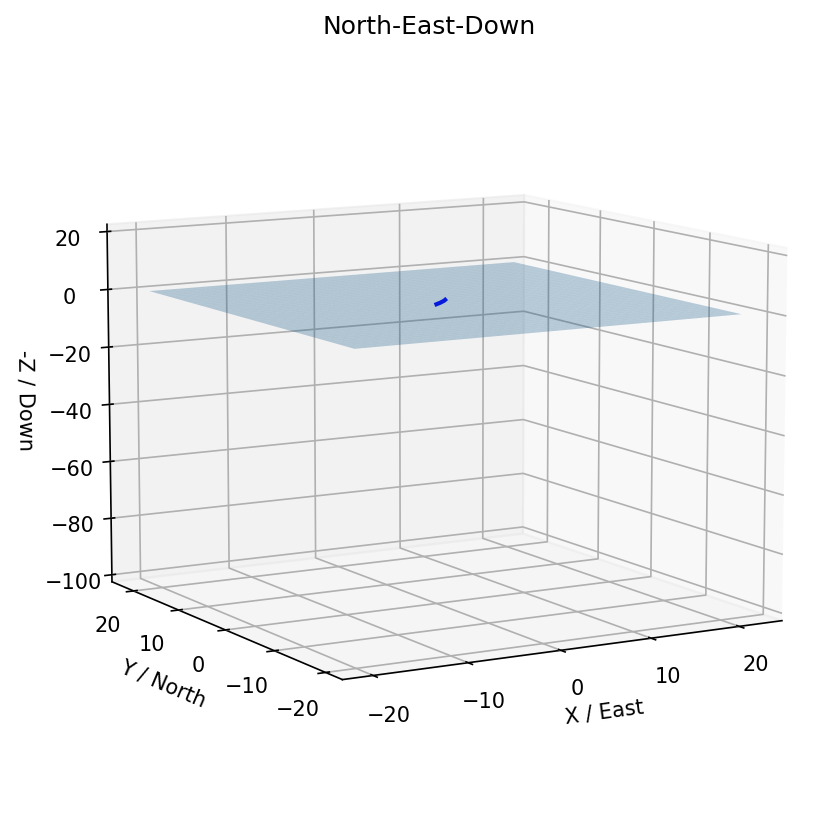

In [115]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [116]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

### Dynamics

In [117]:
def grayscott1d(t, Q):
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
    n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    
    Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    

    tau_force = 1.400326*n_ # [N]


    Z0=np.dot(Re_b(Ret),tau_force[:3])   
    Z1 =d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
    Z2=ne_(dx,dy,dz,DT,Ret).T

    Z= (Z1 + Z2 +Z0)

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N-1)]
                                             +[vessel_mass]
                                             ,RRRR),
                                   Z).T 
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))

    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None)) 
    C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
#     C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None)))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
       

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

    return A1111

In [118]:
tspan = (0., 40)

In [119]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:05:02.852569


### Results

In [120]:
fin=us

In [121]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 18062
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 3.20024337e-03, 1.57485546e-02, ...,
       3.99821402e+01, 3.99939874e+01, 4.00000000e+01])
 t_events: None
        y: array([[ 0.00000000e+00,  1.27315855e-06,  3.08359402e-05, ...,
         6.13165929e+00,  6.13339398e+00,  6.13427434e+00],
       [ 6.90792803e+02,  6.90792804e+02,  6.90792834e+02, ...,
         6.96924295e+02,  6.96926029e+02,  6.96926910e+02],
       [ 1.38158561e+03,  1.38158561e+03,  1.38158564e+03, ...,
         1.38771232e+03,  1.38771405e+03,  1.38771493e+03],
       ...,
       [ 0.00000000e+00,  1.96010187e-12,  3.01883625e-11, ...,
         8.38902951e-06,  7.81105639e-06,  7.77395221e-06],
       [ 0.00000000e+00,  1.98693577e-12,  3.33418353e-11, ...,
         1.34190068e-05,  1.58992650e-05,  1.60419333e-05],
       [ 0.00000000e+00,  2.01363674e-12,  3

In [122]:
t=fin.t

In [123]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


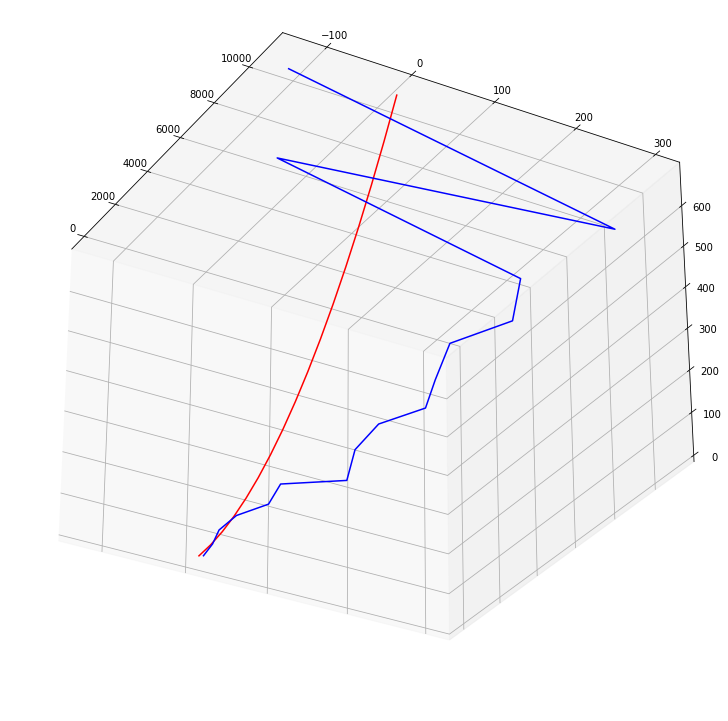

In [124]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [125]:
X,Y,Z

(array([6.13427434e+00, 6.96926910e+02, 1.38771493e+03, 2.07848119e+03,
        2.76393756e+03, 3.45265785e+03, 4.10577181e+03, 4.78947242e+03,
        5.46406884e+03, 6.11112859e+03, 6.77196138e+03, 7.45550751e+03,
        8.00096752e+03, 8.68027041e+03, 9.47800213e+03, 9.71776113e+03,
        1.07358690e+04]),
 array([   5.30313772,    2.28757426,   -3.93731467,    2.64938558,
          26.8193633 ,   26.76112142,   92.56898418,   87.60133566,
         101.45138313,  144.20633646,  141.31187732,  144.1194685 ,
         209.32331123,  204.13189826, -106.64624533,  299.98582063,
        -120.64018214]),
 array([  2.74614317,   6.07016774,  12.80965147,  27.03706945,
         43.07109047,  66.91233699,  87.617651  , 134.1788215 ,
        178.89949733, 217.4380161 , 259.13370497, 323.55507753,
        395.6608864 , 469.88373   , 538.42574099, 609.81546794,
        692.21414065]))

In [126]:
X0,Y0,Z0

(array([    0.        ,   690.79280278,  1381.58560556,  2072.37840834,
         2763.17121112,  3453.96401389,  4144.75681667,  4835.54961945,
         5526.34242223,  6217.13522501,  6907.92802779,  7598.72083057,
         8289.51363335,  8980.30643613,  9671.0992389 , 10361.89204168,
        11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([  0.        ,   2.70904235,  10.83633605,  24.38238107,
         43.34801072,  67.7343917 ,  97.54302418, 132.7757419 ,
        173.43471226, 219.52243647, 271.04174969, 327.99582124,
        390.38815474, 458.22258838, 531.5032951 , 610.23478291,
        694.42189511]))

In [127]:
us=fin.T

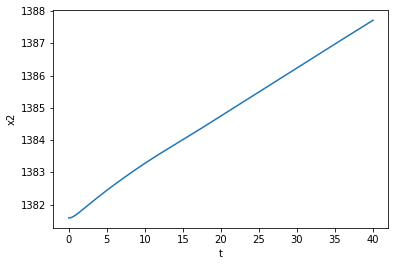

In [128]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

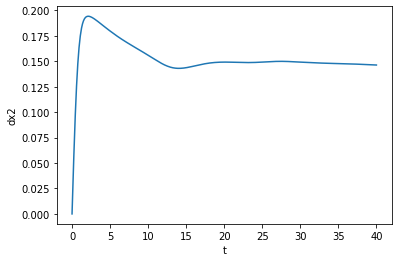

In [129]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

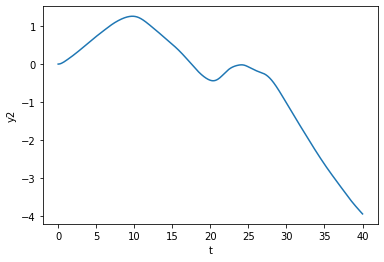

In [130]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

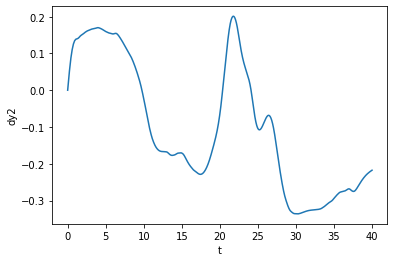

In [131]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

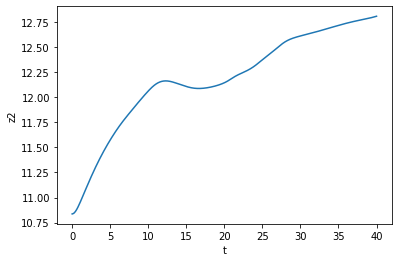

In [132]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

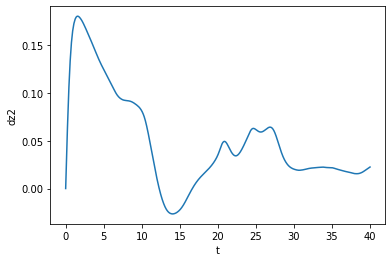

In [133]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

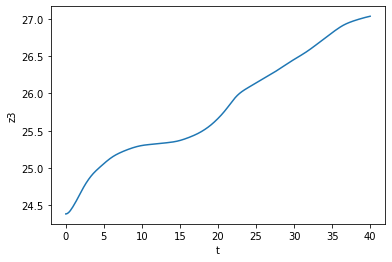

In [134]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

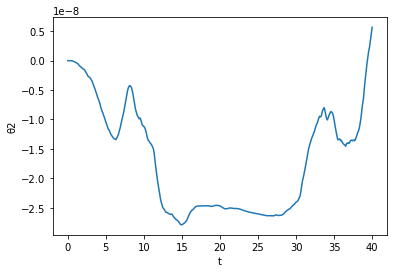

In [135]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

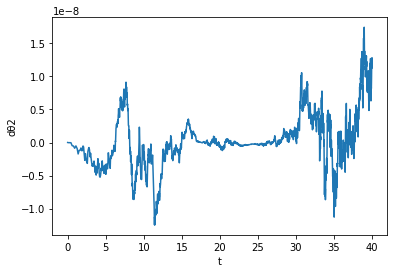

In [136]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

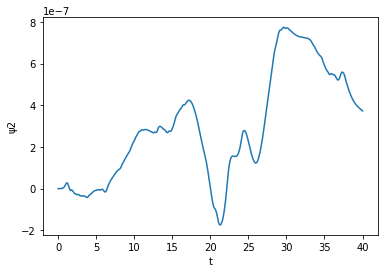

In [137]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

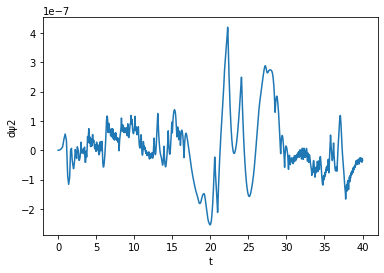

In [138]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()